# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\analysis


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [4]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [5]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [6]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [7]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [186]:
data_hosp_rate_sex_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_age_cat.csv')
data_hosp_rate_cat_sex_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_cat_sex_age_cat.csv')
data_hosp_rate_sex_age_cat_gp = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_age_cat_gp.csv')

data_hosp_rate_sex_age_cat.head()#.shape

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,0,129.0,48.0,2.687500,2019-01-01
1,F,0-4,1,NaN,7.0,NaN,2019-01-01
2,F,15-24,0,159.0,53.0,3.000000,2019-01-01
3,F,15-24,1,15.0,6.0,2.500000,2019-01-01
4,F,25-34,0,232.0,61.0,3.803279,2019-01-01


In [190]:
data_hosp_rate_sex_age_cat = data_hosp_rate_sex_age_cat[data_hosp_rate_sex_age_cat['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_cat_sex_age_cat = data_hosp_rate_cat_sex_age_cat[data_hosp_rate_cat_sex_age_cat['sgss_gp_cov_admitted_binary']==0]
data_hosp_rate_sex_age_cat_gp = data_hosp_rate_sex_age_cat_gp[data_hosp_rate_sex_age_cat_gp['sgss_gp_cov_admitted_binary']==0]

data_hosp_rate_sex_age_cat.head()#.shape

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,0,129.0,48.0,2.687500,2019-01-01
2,F,15-24,0,159.0,53.0,3.000000,2019-01-01
4,F,25-34,0,232.0,61.0,3.803279,2019-01-01
6,F,35-44,0,144.0,47.0,3.063830,2019-01-01
8,F,45-54,0,171.0,54.0,3.166667,2019-01-01


In [192]:
data_hosp_rate_sex_age_cat.describe(include='all')

,sex,age_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,684,684,684.0,684.000000,684.000000,684.000000,684
unique,2,9,NaN,NaN,NaN,NaN,38
top,F,0-4,NaN,NaN,NaN,NaN,2019-01-01
freq,342,76,NaN,NaN,NaN,NaN,18
mean,NaN,NaN,0.0,165.102339,50.000000,3.301033,NaN
std,NaN,NaN,0.0,34.665455,7.296081,0.497288,NaN
min,NaN,NaN,0.0,79.000000,31.000000,1.900000,NaN
25%,NaN,NaN,0.0,141.000000,45.000000,2.977519,NaN
50%,NaN,NaN,0.0,166.000000,50.000000,3.295488,NaN
75%,NaN,NaN,0.0,186.250000,55.000000,3.604804,NaN


In [193]:
data_hosp_rate_cat_sex_age_cat.describe(include='all')

,sex,age_cat,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,5472,5472,4788,5472.0,4688.000000,1585.000000,862.000000,5472
unique,2,9,7,NaN,NaN,NaN,NaN,38
top,F,0-4,Meningitis in bacterial diseases classified el...,NaN,NaN,NaN,NaN,2019-01-01
freq,2736,608,684,NaN,NaN,NaN,NaN,144
mean,NaN,NaN,NaN,0.0,23.492961,15.864353,3.321123,NaN
std,NaN,NaN,NaN,0.0,40.220450,17.242145,0.814667,NaN
min,NaN,NaN,NaN,0.0,-4.000000,0.000000,0.857143,NaN
25%,NaN,NaN,NaN,0.0,0.000000,0.000000,2.833333,NaN
50%,NaN,NaN,NaN,0.0,9.000000,6.000000,3.287302,NaN
75%,NaN,NaN,NaN,0.0,17.000000,34.000000,3.726705,NaN


In [194]:
data_hosp_rate_sex_age_cat_gp.describe(include='all')

,sex,age_cat,gp_count_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value,date
count,1368,1368,1368.000000,1368.0,1368.000000,1368.000000,1368.000000,1368
unique,2,9,NaN,NaN,NaN,NaN,NaN,38
top,F,0-4,NaN,NaN,NaN,NaN,NaN,2019-01-01
freq,684,152,NaN,NaN,NaN,NaN,NaN,36
mean,NaN,NaN,0.500000,0.0,82.551170,25.000000,3.299512,NaN
std,NaN,NaN,0.500183,0.0,24.248718,5.022262,0.719405,NaN
min,NaN,NaN,0.000000,0.0,20.000000,11.000000,1.300000,NaN
25%,NaN,NaN,0.000000,0.0,67.000000,22.000000,2.817340,NaN
50%,NaN,NaN,0.500000,0.0,81.000000,25.000000,3.254032,NaN
75%,NaN,NaN,1.000000,0.0,98.000000,28.000000,3.743056,NaN


### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [58]:
data_hosp_rate_sex_age_cat.isnull().sum()

sex                              0
age_cat                          0
sgss_gp_cov_admitted_binary      0
admitted                        77
population                     362
value                          373
date                             0
dtype: int64

In [61]:
data_hosp_rate_sex_age_cat_groupby_date = data_hosp_rate_sex_age_cat.groupby([data_hosp_rate_sex_age_cat['date']]).sum()
data_hosp_rate_sex_age_cat_groupby_date.head()

,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,
2019-01-01,18,3277.0,958.0,79.392409
2019-02-01,18,3219.0,958.0,84.307462
2019-03-01,18,3356.0,971.0,93.761189
2019-04-01,18,3370.0,953.0,81.422007
2019-05-01,18,3240.0,962.0,88.585208


In [62]:
data_hosp_rate_sex_age_cat_groupby_date['date'] = data_hosp_rate_sex_age_cat_groupby_date.index

data_hosp_rate_sex_age_cat_groupby_date.date = pd.to_datetime(data_hosp_rate_sex_age_cat_groupby_date.date)

data_hosp_rate_sex_age_cat_groupby_date.date = data_hosp_rate_sex_age_cat_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_sex_age_cat_groupby_date.index = data_hosp_rate_sex_age_cat_groupby_date.date

data_hosp_rate_sex_age_cat_groupby_date = data_hosp_rate_sex_age_cat_groupby_date.drop(columns=['date'])

data_hosp_rate_sex_age_cat_groupby_date.head()

,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,
2019-01,18,3277.0,958.0,79.392409
2019-02,18,3219.0,958.0,84.307462
2019-03,18,3356.0,971.0,93.761189
2019-04,18,3370.0,953.0,81.422007
2019-05,18,3240.0,962.0,88.585208


In [195]:
data_hosp_rate_sex_age_cat_groupby_date['value'] = data_hosp_rate_sex_age_cat_groupby_date['value']*1000

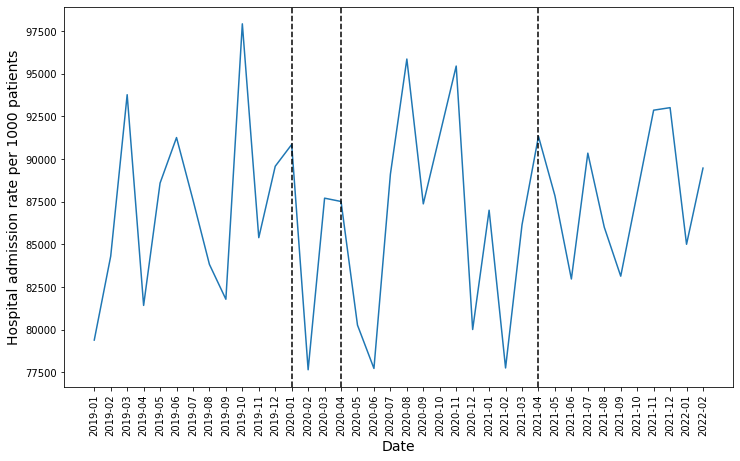

In [196]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(y=data_hosp_rate_sex_age_cat_groupby_date.value, x=data_hosp_rate_sex_age_cat_groupby_date.index, ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_1000_patient.jpg')
plt.show()

### Hospital admission with category

In [78]:
data_hosp_rate_cat_sex_age_cat.head()

,sex,age_cat,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,NaN,0,81.0,26.0,3.115385,2019-01-01
1,F,0-4,NaN,1,6.0,7.0,0.857143,2019-01-01
2,F,0-4,Meningitis in bacterial diseases classified el...,0,NaN,NaN,NaN,2019-01-01
3,F,0-4,Meningitis in bacterial diseases classified el...,1,0.0,0.0,NaN,2019-01-01
4,F,0-4,Other sepsis,0,NaN,NaN,NaN,2019-01-01


In [82]:
data_hosp_rate_cat_sex_age_cat.shape

(10944, 8)

In [80]:
data_hosp_rate_cat_sex_age_cat.isnull().sum()

sex                               0
age_cat                           0
admitted_cat                   1368
sgss_gp_cov_admitted_binary       0
admitted                       1157
population                     5438
value                          9948
date                              0
dtype: int64

In [122]:
#drop rows with missing values
# data_hosp_rate_cat_sex_age_cat = data_hosp_rate_cat_sex_age_cat.dropna(axis='rows')
print(f'shape of data_hosp_rate_cat_sex_age_cat: {data_hosp_rate_cat_sex_age_cat.shape}\n')
data_hosp_rate_cat_sex_age_cat.head()

shape of data_hosp_rate_cat_sex_age_cat: (178, 8)



,sex,age_cat,admitted_cat,sgss_gp_cov_admitted_binary,admitted,population,value,date
10,F,0-4,Pneumonia in diseases classified elsewhere,0,15.0,7.0,2.142857,2019-01-01
18,F,15-24,Meningitis in bacterial diseases classified el...,0,19.0,7.0,2.714286,2019-01-01
20,F,15-24,Other sepsis,0,15.0,6.0,2.500000,2019-01-01
186,M,25-34,Pneumonia in diseases classified elsewhere,0,25.0,6.0,4.166667,2019-01-01
206,M,35-44,ot_externa,0,14.0,7.0,2.000000,2019-01-01


In [123]:
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat.groupby([data_hosp_rate_cat_sex_age_cat['date']]).sum()
data_hosp_rate_cat_sex_age_cat_groupby_date.head()

,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,
2019-01-01,0,88.0,33.0,13.523810
2019-02-01,0,168.0,52.0,26.113095
2019-03-01,0,77.0,20.0,11.452381
2019-04-01,0,105.0,35.0,14.898810
2019-05-01,0,109.0,33.0,16.738095


In [124]:
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat.groupby(['date', 'admitted_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat_groupby_date.reset_index()
data_hosp_rate_cat_sex_age_cat_groupby_date.columns = ['date', 'admitted_cat', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_age_cat_groupby_date

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01-01,Meningitis in bacterial diseases classified el...,2.714286,2.714286,2.714286,2.714286
1,2019-01-01,Other sepsis,2.500000,2.500000,2.500000,2.500000
2,2019-01-01,Pneumonia in diseases classified elsewhere,3.154762,2.142857,4.166667,6.309524
3,2019-01-01,ot_externa,2.000000,2.000000,2.000000,2.000000
4,2019-02-01,Meningitis in bacterial diseases classified el...,2.892857,2.285714,3.500000,5.785714
...,...,...,...,...,...,...
104,2022-01-01,ot_externa,6.809524,6.333333,7.285714,13.619048
105,2022-02-01,Meningitis in bacterial diseases classified el...,5.000000,5.000000,5.000000,5.000000
106,2022-02-01,Pneumonia due to Haemophilus influenzae,2.571429,2.571429,2.571429,2.571429
107,2022-02-01,Pneumonia in diseases classified elsewhere,3.607143,3.500000,3.714286,7.214286


In [125]:
# data_hosp_rate_cat_sex_age_cat_groupby_date['date'] = data_hosp_rate_cat_sex_age_cat_groupby_date.index

data_hosp_rate_cat_sex_age_cat_groupby_date.date = pd.to_datetime(data_hosp_rate_cat_sex_age_cat_groupby_date.date)

data_hosp_rate_cat_sex_age_cat_groupby_date.date = data_hosp_rate_cat_sex_age_cat_groupby_date.date.dt.strftime('%Y-%m')

# data_hosp_rate_cat_sex_age_cat_groupby_date.index = data_hosp_rate_cat_sex_age_cat_groupby_date.date

# data_hosp_rate_cat_sex_age_cat_groupby_date = data_hosp_rate_cat_sex_age_cat_groupby_date.drop(columns=['date'])

data_hosp_rate_cat_sex_age_cat_groupby_date.head()

,date,admitted_cat,value_mean,value_min,value_max,value_sum
0,2019-01,Meningitis in bacterial diseases classified el...,2.714286,2.714286,2.714286,2.714286
1,2019-01,Other sepsis,2.500000,2.500000,2.500000,2.500000
2,2019-01,Pneumonia in diseases classified elsewhere,3.154762,2.142857,4.166667,6.309524
3,2019-01,ot_externa,2.000000,2.000000,2.000000,2.000000
4,2019-02,Meningitis in bacterial diseases classified el...,2.892857,2.285714,3.500000,5.785714


In [126]:
data_hosp_rate_cat_sex_age_cat_groupby_date['admitted_cat'].value_counts()

Meningitis in bacterial diseases classified elsewhere    35
ot_externa                                               32
Pneumonia in diseases classified elsewhere               31
Pneumonia due to Haemophilus influenzae                   4
Streptococcal sepsis                                      4
Other sepsis                                              3
Name: admitted_cat, dtype: int64

In [197]:
data_hosp_rate_cat_sex_age_cat_groupby_date['value_sum'] = data_hosp_rate_cat_sex_age_cat_groupby_date['value_sum']*1000

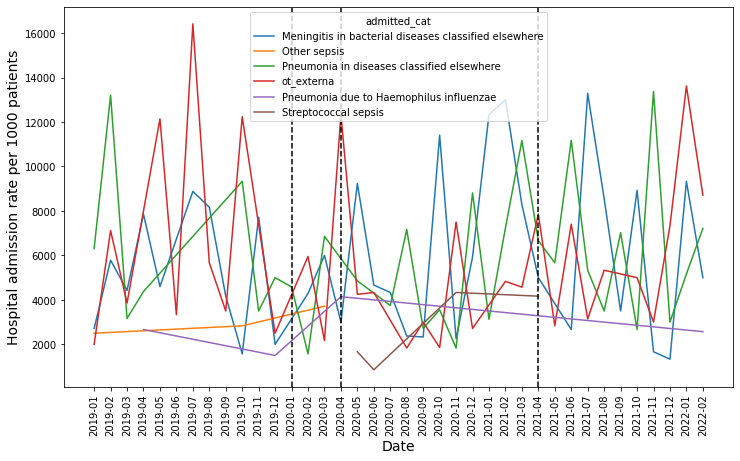

In [198]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_date, y="value_sum", x="date", hue="admitted_cat", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.locator_params(axis='x', nbins=5)
# plt.(np.arange(min(data_hosp_rate_cat_sex_age_cat_groupby_date.date), max(data_hosp_rate_cat_sex_age_cat_groupby_date.date))+1, 1.0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
plt.show()

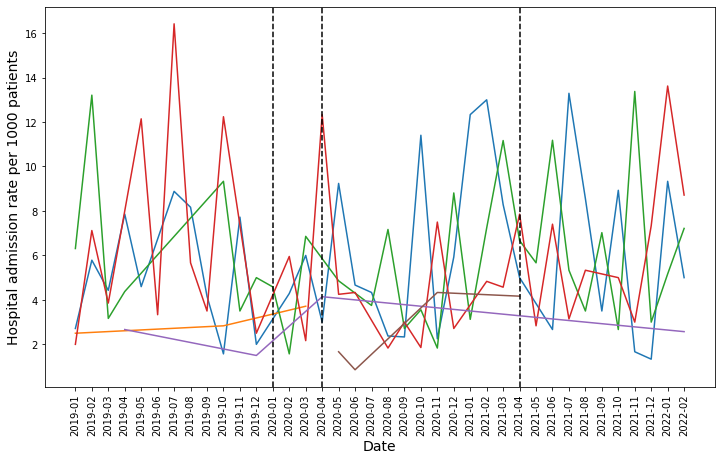

In [167]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_cat_sex_age_cat_groupby_date, y="value_sum", x="date", hue="admitted_cat", ax=ax1)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
# plt.locator_params(axis='x', nbins=5)
# plt.(np.arange(min(data_hosp_rate_cat_sex_age_cat_groupby_date.date), max(data_hosp_rate_cat_sex_age_cat_groupby_date.date))+1, 1.0)
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
plt.show()

### Hospital admission rate with GP consultation

In [159]:
data_hosp_rate_sex_age_cat_gp.head()

,sex,age_cat,gp_count_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value,date
0,F,0-4,0,0,47.0,23.0,2.043478,2019-01-01
1,F,0-4,0,1,NaN,NaN,NaN,2019-01-01
2,F,0-4,1,0,82.0,25.0,3.280000,2019-01-01
3,F,0-4,1,1,NaN,NaN,NaN,2019-01-01
4,F,15-24,0,0,47.0,19.0,2.473684,2019-01-01


In [160]:
data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp.groupby([data_hosp_rate_sex_age_cat_gp['date']]).sum()
data_hosp_rate_sex_age_cat_gp_groupby_date.head()

,gp_count_admitted_binary,sgss_gp_cov_admitted_binary,admitted,population,value
date,,,,,
2019-01-01,36,36,3257.0,918.0,125.951309
2019-02-01,36,36,3185.0,915.0,123.985023
2019-03-01,36,36,3337.0,912.0,125.308568
2019-04-01,36,36,3347.0,912.0,135.768287
2019-05-01,36,36,3225.0,907.0,116.909938


In [176]:
data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp.groupby(['date', 'gp_count_admitted_binary']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp_groupby_date.reset_index()
data_hosp_rate_sex_age_cat_gp_groupby_date.columns = ['date', 'gp_count_admitted_binary', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_sex_age_cat_gp_groupby_date

,date,gp_count_admitted_binary,value_mean,value_min,value_max,value_sum
0,2019-01-01,0,3.282468,1.769231,5.625000,62.366883
1,2019-01-01,1,3.346549,1.600000,4.923077,63.584426
2,2019-02-01,0,3.224089,1.695652,4.235294,58.033598
3,2019-02-01,1,3.297571,2.281250,4.272727,65.951425
4,2019-03-01,0,3.174970,1.892857,4.444444,60.324426
...,...,...,...,...,...,...
71,2021-12-01,1,3.336882,2.250000,4.100000,63.400763
72,2022-01-01,0,3.268298,2.000000,4.689655,62.097658
73,2022-01-01,1,3.405686,2.157895,5.366667,64.708035
74,2022-02-01,0,3.601522,1.571429,5.100000,64.827398


In [179]:
# data_hosp_rate_sex_age_cat_gp_groupby_date['date'] = data_hosp_rate_sex_age_cat_gp_groupby_date.index

data_hosp_rate_sex_age_cat_gp_groupby_date.date = pd.to_datetime(data_hosp_rate_sex_age_cat_gp_groupby_date.date)

data_hosp_rate_sex_age_cat_gp_groupby_date.date = data_hosp_rate_sex_age_cat_gp_groupby_date.date.dt.strftime('%Y-%m')

# data_hosp_rate_sex_age_cat_gp_groupby_date.index = data_hosp_rate_sex_age_cat_gp_groupby_date.date

# data_hosp_rate_sex_age_cat_gp_groupby_date = data_hosp_rate_sex_age_cat_gp_groupby_date.drop(columns=['date'])

data_hosp_rate_sex_age_cat_gp_groupby_date.head()

,date,gp_count_admitted_binary,value_mean,value_min,value_max,value_sum
0,2019-01,0,3.282468,1.769231,5.625000,62.366883
1,2019-01,1,3.346549,1.600000,4.923077,63.584426
2,2019-02,0,3.224089,1.695652,4.235294,58.033598
3,2019-02,1,3.297571,2.281250,4.272727,65.951425
4,2019-03,0,3.174970,1.892857,4.444444,60.324426


In [199]:
data_hosp_rate_sex_age_cat_gp_groupby_date['value_sum'] = data_hosp_rate_sex_age_cat_gp_groupby_date['value_sum']*1000

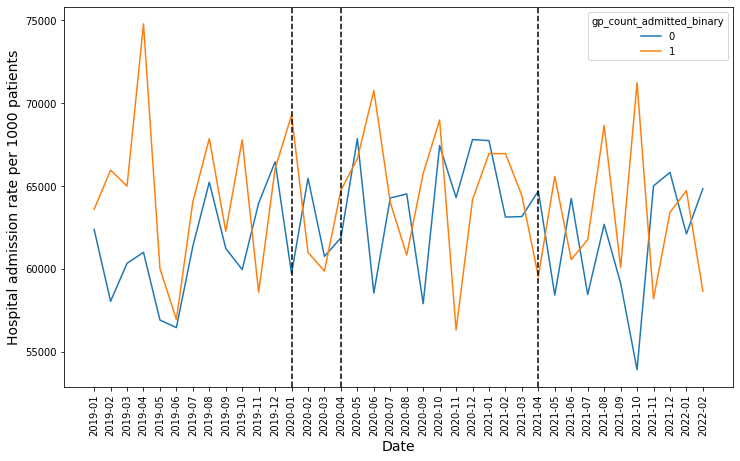

In [200]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_sex_age_cat_gp_groupby_date, y="value_sum", x="date", hue="gp_count_admitted_binary", ax=ax1)

plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient.jpg')
plt.show()

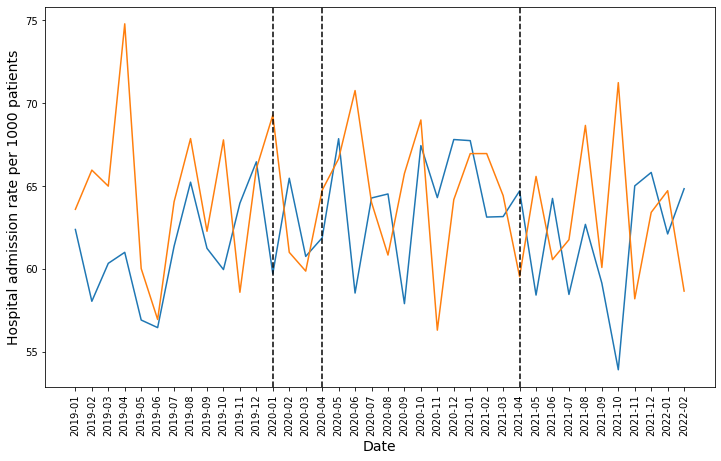

In [181]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sns.lineplot(data=data_hosp_rate_sex_age_cat_gp_groupby_date, y="value_sum", x="date", hue="gp_count_admitted_binary", ax=ax1)

plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_nolegend.jpg')
plt.show()